In [1]:
from kglib.utils import HelperFunctions, HDF5_Helpers
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

from kglib.cross_correlation.GenericSearch import Process_Data
from kglib.utils.StarData import get_vsini
from collections import defaultdict
import os

logger = logging.getLogger()
logger.setLevel(logging.INFO)
%matplotlib inline

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.
rv/:
 continpars@    fxcor           rvcorrect       rvreidlines
 filtpars@      keywpars@       rvidlines


In [24]:
sample = HelperFunctions.read_observed_targets()
sample.Temperature = pd.to_numeric(sample.Temperature, errors='coerce')
sample.loc[76, 'Temperature'] = np.nan  # I don't believe the 2nd detection for HIP 14764
sample.loc[137, 'Temperature'] = np.nan  # Bad temperature for 2nd detection of HIP 22958
detections = sample.loc[(sample.Temperature.notnull()) & (sample.Temperature < 90000)].copy()

detections.loc[detections.identifier == 'HIP 22958', ['Date', 'Temperature', 'vsini_sec', '[Fe/H]']]

,Date,Temperature,vsini_sec,[Fe/H]
136,20130915,5900,30,-0.5


In [25]:
# Set the addmode to use for everything to simple, except for one star where we need to use ml to detect...
detections['addmode'] = 'simple'
detections.loc[detections.identifier == 'HIP 18396', 'addmode'] = 'ml'

In [26]:
detections[['identifier', 'SpT', 'configuration', 'Instrument', 'Date', 'Temperature', '[Fe/H]', 'vsini_sec']].head(20)

,identifier,SpT,configuration,Instrument,Date,Temperature,[Fe/H],vsini_sec
10,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",HRS,20130812,5600,-0.5,30
11,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",IGRINS,20150806,6000,0.0,30
17,HIP 3478,B5V,B5V,TS23,20140112,5800,-0.5,5
30,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,0.0,30
43,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-0.5,5
44,HR 545,B9.5IV,B9V,TS23,20131021,4500,-0.5,5
45,HR 545,B9.5IV,B9V,TS23,20140111,4500,0.0,5
48,HR 604,B8V+A0V,"(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A0V; 63.67y e=.93); 9.580"")",TS23,20131020,5000,0.5,5
51,HIP 10732,A1Vn,A1Vn,IGRINS,20141014,5500,0.0,5
52,HIP 10732,A1Vn,A1Vn,IGRINS,20150301,5700,0.0,10


In [27]:
detections.loc[detections.identifier == 'HIP 22958', ['Date', 'Instrument', 'parsed_date', 
                                                      'Temperature', 'vsini_sec', '[Fe/H]']]


,Date,Instrument,parsed_date,Temperature,vsini_sec,[Fe/H]
136,20130915,CHIRON,NaN,5900,30,-0.5


In [16]:

import Analyze_CCF
reload(Analyze_CCF)
reload(HDF5_Helpers)
interface = HDF5_Helpers.Full_CCF_Interface(cache=False, update_cache=False, 
                                            cache_fname='/home/kgullikson/.PythonModules/CCF_metadata.csv')

In [28]:
pd.set_option('max_colwidth',400)
starname, date, inst, addmode = 'HIP 22958', '2013-09-15', 'CHIRON', 'simple'
interface.get_measured_temperature(starname=starname, date=date, instrument=inst, 
                                   Tmax=5900, addmode=addmode, feh=-0.5, vsini=30)

INFO:root:HIP 22958, 2013-09-16, CHIRON, simple


,Tmeas,Tmeas_err,[Fe/H],logg,rv,significance,vsini,Star,Date,Instrument,addmode
0,5899.991984,216.006675,-0.5,4.5,43,12.488445,30,HIP 22958,2013-09-16,CHIRON,simple


# Get the measured temperature for every star

In [27]:
detections = detections.loc[detections.identifier == 'HIP 37322']

In [28]:
# Change instrument 'HRS' to 'HET'
detections.loc[detections.Instrument == 'HRS', 'Instrument'] = 'HET'

# Make a date string suitable for the HDF5 interface code
detections['parsed_date'] = detections.Date.astype(str).map(lambda s: '{}-{}-{}'.format(s[:4], s[4:6], s[6:8]))

# Get the updated information for each row
def get_tmeas(row):
    try:
        data = interface.get_measured_temperature(starname=row['identifier'],
                                                  date=row['parsed_date'],
                                                  instrument=row['Instrument'],
                                                  Tmax=row['Temperature'],
                                                  addmode=row['addmode'],
                                                  feh=row['[Fe/H]'],
                                                  vsini=row['vsini_sec'])
        Tmeas, Tmeas_err, sig = data.Tmeas.item(), data.Tmeas_err.item(), data.significance.item()
    except ValueError:
        print('Something weird happened with this row! Returning NaNs...')
        print(row)
        Tmeas, Tmeas_err, sig = np.nan, np.nan, np.nan
    #print(Tmeas, Tmeas_err, sig)
    return Tmeas, Tmeas_err, sig
out = detections.apply(get_tmeas, axis=1)

detections['Tmeas'], detections['Tmeas_err'], detections['significance'] = zip(*out)
detections[['identifier', 'SpT', 'configuration', 'Instrument', 'Date', 'Temperature', '[Fe/H]', 'vsini_sec', 'Tmeas', 'Tmeas_err', 'significance']].head()

INFO:root:HIP 37322, 2014-11-14, CHIRON, simple


,identifier,SpT,configuration,Instrument,Date,Temperature,[Fe/H],vsini_sec,Tmeas,Tmeas_err,significance
219,HIP 37322,B5V,"(5.76B5Vn + 8.75; 1.280"")",CHIRON,20141113,8200,-0.5,30,8200.028372,199.992118,45.578797


In [ ]:
cols = [u'identifier', u'SpT', u'configuration', u'Instrument', u'Date', u'Temperature',
        u'Velocity', u'vsini_sec', u'[Fe/H]', u'significance', 
        u'Comments', u'Rank', u'Keck', u'VLT', u'Gemini', 
        u'Imaging_Detecton', u'addmode', u'parsed_date', u'Tmeas', u'Tmeas_err']
detections[cols].to_csv('/home/kgullikson/School/Research/BinaryInference/Companion_Data.csv', 
                        encoding='utf-8', sep='|')

In [ ]:
detections = pd.read_csv('/home/kgullikson/School/Research/BinaryInference/Companion_Data.csv', sep='|', index_col=0)
detections.loc[detections.identifier == 'HIP 46283']

In [25]:
df = pd.read_csv('/home/kgullikson/School/Research/BinaryInference/data/Companion_Data.csv', sep='|', index_col=0)
df.rename(columns=dict(identifier='Star'), inplace=True)

,Star,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,[Fe/H],significance,Comments,Rank,Keck,VLT,Gemini,Imaging_Detecton,addmode,parsed_date,Tmeas,Tmeas_err


In [29]:
df = detections.loc[detections.identifier == 'HIP 22958'].copy()
df['Star'] = df.identifier
df['Tmeas'] = 5900
df['Tmeas_err'] = 216.006675
df['significance'] = 12.488445

In [30]:
corrected = interface.convert_measured_to_actual(df)

$T = 5761.99733373^{+158.236442326}_{-158.223692412}$
$T = 5761.99733373^{+158.236442326}_{-158.223692412}$


In [22]:
df

,identifier,RA/DEC (J2000),plx,Vmag,Kmag,vsini,SpT,configuration,Instrument,Date,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,addmode,Star,Tmeas,Tmeas_err,significance
77,HIP 14764,03 10 38.79281 +11 52 21.4458,7.33,5.965,6.049,282,B8V,B8V,TS23,20140122,...,1,n,n,n,NaN,simple,HIP 14764,5900,215.970927,25.330855


In [ ]:
corrected.Corrected_Temperature.hist()

In [33]:
from Distributions import teff2mass

ImportError: No module named fitters

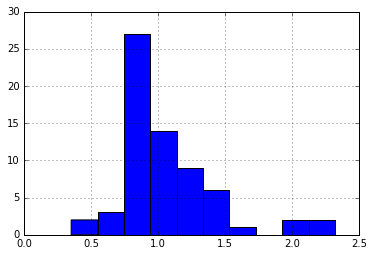

In [25]:
corrected['Mass'] = corrected.Corrected_Temperature.map(teff2mass)
corrected['Mass'].hist()

In [26]:
combined = pd.merge(df, corrected.reset_index(drop=True), on='Star', how='left')
combined.head()

,Star,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,[Fe/H],significance,...,Gemini,Imaging_Detecton,addmode,parsed_date,Tmeas,Tmeas_err,Corrected_Temperature,T_lowerr,T_uperr,Mass
0,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",HET,20130812,5600,6.985,30,-0.5,29.055830,...,n,NaN,simple,2013-08-12,5600.047668,215.998031,5732.020192,111.956254,111.982127,0.999831
1,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",IGRINS,20150806,6000,2.853,30,0.0,8.796868,...,n,NaN,simple,2015-08-06,6000.008180,216.001275,5732.020192,111.956254,111.982127,0.999831
2,HIP 3478,B5V,B5V,TS23,20140112,5800,-46.170,5,-0.5,31.099362,...,n,NaN,simple,2014-01-12,5799.802745,215.990025,5524.152869,149.773113,149.773877,0.957460
3,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,4.825,30,0.0,13.244871,...,Y,NaN,simple,2014-10-14,3399.871770,215.846391,3342.732718,154.357141,154.313632,0.352539
4,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-34.854,5,-0.5,36.996533,...,n,NaN,simple,2014-10-14,4499.706320,215.693513,4312.191145,87.255325,87.252411,0.728462


In [27]:
import Mamajek_Table
import SpectralTypeRelations
MS = SpectralTypeRelations.MainSequence()
MT = Mamajek_Table.MamajekTable()
sptnum2mass = MT.get_interpolator('SpTNum', 'Msun')
sptnum = combined.SpT.map(MS.SpT_To_Number)
combined['M1'] = sptnum.map(sptnum2mass)
combined.to_csv('/home/kgullikson/School/Research/BinaryInference/Corrected_Companion_Data.csv', 
                sep='|', encoding='utf-8')
combined[['Star', 'SpT', 'configuration', 'M1', 'Temperature', 'Corrected_Temperature', 'Mass']].head()

,Star,SpT,configuration,M1,Temperature,Corrected_Temperature,Mass
0,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",2.5,5600,5732.020192,0.999831
1,HIP 2548,B9.5V,"(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.61; 27.5"")",2.5,6000,5732.020192,0.999831
2,HIP 3478,B5V,B5V,4.6,5800,5524.152869,0.957460
3,HIP 5310,A3V,(A3V + ?; ?),2.0,3400,3342.732718,0.352539
4,HR 545,B9.5IV,B9V,2.5,4500,4312.191145,0.728462


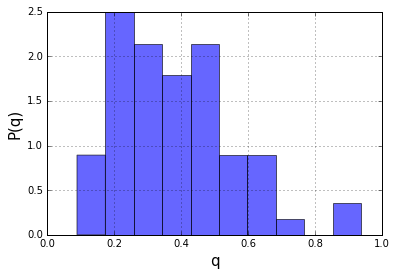

In [28]:
combined['q'] = combined.Mass / combined.M1
combined.drop_duplicates(subset=['Star'])['q'].hist(alpha=0.6, normed=True)
plt.xlabel('q', fontsize=15)
plt.ylabel('P(q)', fontsize=15)
#qplot = np.arange(0.05, 1, 0.01)
#gamma = 0.2
#plt.plot(qplot, (1-gamma)*qplot**(-gamma), 'r-', lw=3, alpha=0.6)
plt.savefig('Figures/MyMassRatios.pdf')

# Measure the companion RVs for each detection.

In [2]:
detections = pd.read_csv('/home/kgullikson/School/Research/BinaryInference/Companion_Data.csv', sep='|', index_col=0)
detections.rename(columns={'[Fe/H]': 'feh', 'addmode': 'best_addmode'}, inplace=True)
detections[['identifier', 'Instrument', 'parsed_date', 'Temperature', 'vsini_sec', 'feh']].head()

,identifier,Instrument,parsed_date,Temperature,vsini_sec,feh
10,HIP 2548,HET,2013-08-12,5600,30,-0.5
11,HIP 2548,IGRINS,2015-08-06,6000,30,0.0
17,HIP 3478,TS23,2014-01-12,5800,5,-0.5
30,HIP 5310,IGRINS,2014-10-14,3400,30,0.0
43,HR 545,IGRINS,2014-10-14,4500,5,-0.5


In [4]:
# Check if the filename actually exists. If not, there is a UT/civil date disagreement.
hdf_int = HDF5_Helpers.Full_CCF_Interface()

In [5]:
import datetime
def check_date(date, possible_dates, fall2user=True):
    if date in possible_dates:
        return date
    elif len(possible_dates) == 1:
        return possible_dates[0]
    
    elif fall2user:
        print('\nDataFrame date is : {}\nPossible dates are'.format(date))
        for i, d in enumerate(possible_dates):
            print('[{}]: {}'.format(i+1, d))
        
        idx = int(raw_input('Enter the number of the correct date.')) - 1
        return possible_dates[idx]
    raise KeyError
    
def get_true_date(row):
    instrument = row.Instrument
    date = row.parsed_date
    star = row.identifier
    interface = hdf_int._interfaces[instrument]
    possible_dates = interface.list_dates(star)
    try:
        return check_date(date, possible_dates, fall2user=False)
    except KeyError:
        year, month, day = [int(s) for s in date.split('-')]
        t = datetime.datetime(year=year, month=month, day=day) + datetime.timedelta(1)
        new_date = '{}-{:02d}-{:02d}'.format(t.year, t.month, t.day)
        return check_date(new_date, possible_dates, fall2user=True)
        
detections['UT_date'] = detections.apply(get_true_date, axis=1)

In [6]:
#detections[['identifier', 'Instrument', 'parsed_date', 'UT_date', 'Temperature', 'vsini_sec', 'feh', 'Velocity', 'best_addmode']].head()
detections.loc[detections.identifier == 'HIP 22833']

,identifier,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,feh,significance,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
132,HIP 22833,A3V,"(A3V + ?; .21"")",IGRINS,20141015,5100,8.626,10,0.0,20.512726,...,1,n,n,Y,NaN,simple,2014-10-15,5099.814008,216.032768,2014-10-16
133,HIP 22833,A3V,"(A3V + ?; .21"")",TS23,20140122,4700,-12.222,5,-0.5,41.894333,...,1,n,n,Y,NaN,simple,2014-01-22,4700.550246,215.806380,2014-01-22


In [7]:
home = os.environ['HOME']
instrument_dirs = dict(TS23='{}/School/Research/McDonaldData'.format(home),
                       CHIRON='{}/School/Research/CHIRON_data'.format(home),
                       HET='{}/School/Research/HET_data'.format(home),
                       IGRINS='{}/School/Research/IGRINS_data'.format(home))

oh_file = "{}/School/Research/IGRINS_data/plp/master_calib/ohlines.dat".format(home)
def add_oh_lines(oh_file, badregions=[], minstrength=1.0, tol=0.05):
    oh_data = pd.read_csv(oh_file, header=None, sep=" ", skipinitialspace=True, names=['wave', 'strength'])
    oh = oh_data[oh_data['strength'] > minstrength].copy()
    n = 1.0 + 2.735182e-4 + 131.4182 / oh['wave'] ** 2 + 2.76249e8 / oh['wave'] ** 4
    oh['wave'] = oh['wave'] / (n * 10.0)
    for wave in oh['wave'].values:
        badregions.append([wave - tol, wave + tol])
    return badregions
settings = dict(TS23=dict(badregions=[[567.5, 575.5],
                                      [588.5, 598.5],
                                      [627, 632],
                                      [647, 655],
                                      [686, 706],
                                      [716, 734],
                                      [759, 9e9]], 
                          interp_regions=[], 
                          trimsize=10),
               HET=dict(badregions = [[0, 450.],
                                      [567.5, 575.5],
                                      [588.5, 598.5],
                                      [627, 632],
                                      [647, 655],
                                      [686, 706],
                                      [716, 734],
                                      [759, 9e9]],
                        interp_regions = [],
                        trimsize = 10),
               CHIRON=dict(badregions = [[567.5, 575.5],
                                         [588.5, 598.5],
                                         [627, 632],
                                         [647, 655],
                                         [686, 706],
                                         [716, 734],
                                         [759, 9e9]],
                           interp_regions = [],
                           trimsize = 10),
               IGRINS=dict(badregions = [[0, 1510],
                                         [1740, 2090],  
                                          [2380, 2500]],
                           interp_regions=add_oh_lines(oh_file, badregions=[]),
                           trimsize=10
                            ))





In [11]:
from Correlate import get_rv
def measure_rv(row):
    row_dict = row.to_dict()
    path = '{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.0f}'.format(**row_dict)
    print(path)
    if path not in hdf_int._interfaces[row['Instrument']].hdf5:
        path = '{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.1f}'.format(**row_dict)
    try:
        ds = hdf_int._interfaces[row['Instrument']].hdf5[path]
    except KeyError:
        #ds = hdf_int._interfaces[row['Instrument']].hdf5['{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.1f}'.format(**row_dict)]
        print('Dataset not found for the following row:')
        print(row)
        df = pd.DataFrame(data=dict(addmode=None, RV=np.nan, RV_err=np.nan, CCF=np.nan, vbary=np.nan), index=(0,))
        for key in row.keys():
            df[key] = row[key]
        return df
    
    # 1. Read in the original file, find the number of pixels
    filename = os.path.join(instrument_dirs[row['Instrument']], ds.attrs['fname'])
    vsini_prim = prim_vsini = get_vsini([filename])[0]
    orders = Process_Data(filename, logspacing=True,
                          extensions=True, vsini=vsini_prim,
                          reject_outliers=True, **settings[row['Instrument']])
    Npix = sum([o.size() for o in orders])

    
    # 2. Read in the CCF data from the dataset. If the max is significantly different than vel_max, 
    #    check if it is close to vel_max + vbary. If so, add vbary to the velocity axis
    vel, corr = ds.value
    vel_offset = 0.0
    if abs(vel[np.argmax(corr)] - ds.attrs['vel_max']) > 0.5:
        if abs(vel[np.argmax(corr)] + ds.attrs['vbary'] - ds.attrs['vel_max']) < 0.5:
            vel_offset = ds.attrs['vbary']
        else:
            raise ValueError('Something is weird with the velocity for dataset {} (instrument {})'.format(ds.name, row['Instrument']))
    print('Velocity offset: {}'.format(vel_offset))
    
    # 3. Find the best rv with associated error using the maximum-likelihood-added CCF.
    #    May need to add a mechanism to give get_rv a region to search (or just don't give it the whole arrays...)
    rv_dict = defaultdict(list)
    for addmode in ['ml', 'dc', 'simple']:
        new_ds = hdf_int._interfaces[row['Instrument']].hdf5[ds.name.replace('addmode-'+row['best_addmode'], 'addmode-'+addmode)]
        vel, corr = new_ds.value
        print(vel)
        vel += vel_offset
        good = np.abs(vel - ds.attrs['vel_max']) < 25
        rv, rv_err, ccf = get_rv(vel[good], corr[good], Npix)
        rv_dict['addmode'].append(addmode)
        rv_dict['RV'].append(rv)
        rv_dict['RV_err'].append(rv_err)
        rv_dict['CCF'].append(ccf)
        rv_dict['vbary'].append(new_ds.attrs['vbary'])
    
    df = pd.DataFrame(data=rv_dict)
    for key in row.keys():
        df[key] = row[key]
    return df

out = []
for _, row in detections.iterrows():
    out.append(measure_rv(row))
rv_data = pd.concat(out, ignore_index=True)
rv_data.head()

HIP 2548/2013-08-12/T5600_logg4.5_metal-0.5_addmode-simple_vsini30
/home/kgullikson/School/Research/HET_data/20130812/HIP_2548-0.fits 144.0
Removing order 62
Removing order 58
Removing order 57
Removing order 55
Removing order 54
Removing order 48
Warning! Bad region covers the middle of order 17
Removing full order!
Removing order 45
Removing order 39
Removing order 12
Removing order 11
Removing order 10
Removing order 9
Removing order 8
Removing order 7
Removing order 6
Removing order 5
Removing order 4
Removing order 3
Removing order 2
Removing order 1
Removing order 0
Velocity offset: 0.0
[ 1022.33403963  1021.12816176  1019.92228389 ...,  -974.59971065
  -975.80558852  -977.01146639]
[ 1022.33403963  1021.12816176  1019.92228389 ...,  -974.59971065
  -975.80558852  -977.01146639]
[ 1022.33403963  1021.12816176  1019.92228389 ...,  -974.59971065
  -975.80558852  -977.01146639]
HIP 2548/2015-08-06/T6000_logg4.5_metal0.0_addmode-simple_vsini30
/home/kgullikson/School/Research/IGRINS_

,CCF,RV,RV_err,addmode,vbary,identifier,SpT,configuration,Instrument,Date,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
0,0.355765992245,7.242255,0.197262,ml,22.67,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,HET,20130812,...,1,n,Y,n,NaN,simple,2013-08-12,5600.047668,215.998031,2013-08-12
1,0.348065823561,7.303496,0.207293,dc,22.67,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,HET,20130812,...,1,n,Y,n,NaN,simple,2013-08-12,5600.047668,215.998031,2013-08-12
2,0.29957629237,7.366654,0.258603,simple,22.67,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,HET,20130812,...,1,n,Y,n,NaN,simple,2013-08-12,5600.047668,215.998031,2013-08-12
3,0.120380960034,-5.777667,0.974358,ml,24.39,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,IGRINS,20150806,...,1,n,Y,n,NaN,simple,2015-08-06,6000.008180,216.001275,2015-08-06
4,0.119809777985,-5.844623,0.985428,dc,24.39,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,IGRINS,20150806,...,1,n,Y,n,NaN,simple,2015-08-06,6000.008180,216.001275,2015-08-06


In [12]:
rv_data.loc[rv_data.identifier == 'HIP 46283']

,CCF,RV,RV_err,addmode,vbary,identifier,SpT,configuration,Instrument,Date,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
166,0.328374803399,-69.165878,0.060594,ml,12.88,HIP 46283,B6V,B6V,CHIRON,20131122,...,1,n,Y,n,NaN,simple,2013-11-22,9400,215,2013-11-23
167,0.319020697539,-69.157634,0.065074,dc,12.88,HIP 46283,B6V,B6V,CHIRON,20131122,...,1,n,Y,n,NaN,simple,2013-11-22,9400,215,2013-11-23
168,0.272770348313,-69.231713,0.076850,simple,12.88,HIP 46283,B6V,B6V,CHIRON,20131122,...,1,n,Y,n,NaN,simple,2013-11-22,9400,215,2013-11-23
169,0.334943902363,14.409229,0.060398,ml,5.38,HIP 46283,B6V,B6V,CHIRON,20140223,...,1,n,Y,n,NaN,simple,2014-02-23,9200,215,2014-02-24
170,0.324990614283,14.422947,0.064664,dc,5.38,HIP 46283,B6V,B6V,CHIRON,20140223,...,1,n,Y,n,NaN,simple,2014-02-23,9200,215,2014-02-24
171,0.275291919545,14.505122,0.076653,simple,5.38,HIP 46283,B6V,B6V,CHIRON,20140223,...,1,n,Y,n,NaN,simple,2014-02-23,9200,215,2014-02-24
172,0.36881040053,-75.445304,0.054559,ml,0.80,HIP 46283,B6V,B6V,CHIRON,20140315,...,1,n,Y,n,NaN,simple,2014-03-15,9200,215,2014-03-16
173,0.359961017599,-75.444854,0.057771,dc,0.80,HIP 46283,B6V,B6V,CHIRON,20140315,...,1,n,Y,n,NaN,simple,2014-03-15,9200,215,2014-03-16
174,0.321321426504,-75.454258,0.065738,simple,0.80,HIP 46283,B6V,B6V,CHIRON,20140315,...,1,n,Y,n,NaN,simple,2014-03-15,9200,215,2014-03-16


In [28]:
rv_data.to_csv('Companion_RV_data.csv', sep='|', encoding='utf-8')

In [8]:
rv_data = pd.read_csv('Companion_RV_data.csv', sep='|')

(-46.169918417978451, -23.16, -23.009918417978454)
23.16


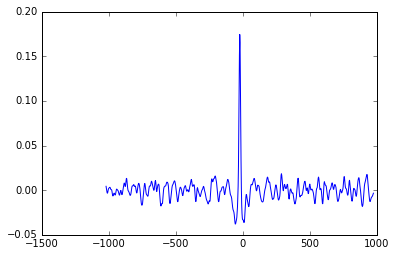

In [80]:
def plot_ccf(**row):
    ds = hdf_int._interfaces[row['Instrument']].hdf5['{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{addmode}_vsini{vsini_sec:.0f}'.format(**row)]
    vel, corr = ds.value
    plt.plot(vel, corr)
    print(ds.attrs['vel_max'], ds.attrs['vbary'], vel[np.argmax(corr)])
    print(abs(vel[np.argmax(corr)] - ds.attrs['vel_max']))

pars = dict(Instrument='TS23',
            identifier='HIP 3478',
            UT_date='2014-01-12',
            Temperature=5800,
            logg=4.5,
            feh=-0.5,
            addmode='simple',
            vsini_sec=5)

%matplotlib inline
plot_ccf(**pars)

# Remake CCFs
What is the velocity when I do the barycentric correction correctly?

In [92]:
detections[['identifier', 'Instrument', 'parsed_date', 'UT_date', 'Temperature', 'vsini_sec', 'feh', 'Velocity', 'best_addmode']].head()

,identifier,Instrument,parsed_date,UT_date,Temperature,vsini_sec,feh,Velocity,best_addmode
10,HIP 2548,HET,2013-08-12,2013-08-12,5600,30,-0.5,6.985,simple
11,HIP 2548,IGRINS,2015-08-06,2015-08-06,6000,30,0.0,2.853,simple
17,HIP 3478,TS23,2014-01-12,2014-01-12,5800,5,-0.5,-46.170,simple
30,HIP 5310,IGRINS,2014-10-14,2014-10-15,3400,30,0.0,4.825,simple
43,HR 545,IGRINS,2014-10-14,2014-10-15,4500,5,-0.5,-34.854,simple


In [8]:
import StellarModel
from astropy import units as u
from astropy.io import fits
import Broaden
import GenericSearch
import StarData
import Correlate
import SpectralTypeRelations

hdf5_file = '/media/ExtraSpace/PhoenixGrid/TS23_Grid.hdf5'
Tvalues = [5800]
metal_values = [0.0]
logg_values = [4.5]
vsini_values = [5]

model_list = StellarModel.GetModelList(type='hdf5',
                                       hdf5_file=hdf5_file,
                                       temperature=Tvalues,
                                       metal=metal_values,
                                       logg=logg_values)
modeldict, processed = StellarModel.MakeModelDicts(model_list, type='hdf5', hdf5_file=hdf5_file,
                                                   vsini_values=vsini_values, vac2air=True, logspace=True)
model = modeldict[5800][4.5][0.0][0.0][5]
l_idx = 0
r_idx = model.size()
model = Broaden.RotBroad(model[l_idx:r_idx], 5.0 * u.km.to(u.cm), linear=True)

In [107]:

MS = SpectralTypeRelations.MainSequence()

fname = '/home/kgullikson/School/Research/McDonaldData/20140112/HIP_3478.fits'
header = fits.getheader(fname)
vbary = GenericSearch.HelCorr_IRAF(header, observatory='mcdonald')
vsini_prim = StarData.get_vsini([fname])[0]
spt = StarData.GetData(header['OBJECT']).spectype
prim_teff = MS.Interpolate('Temperature', spt)
orders = GenericSearch.Process_Data(fname, vsini=vsini_prim, reject_outliers=True, 
                                    logspacing=True, extensions=True, **settings['TS23'])


INFO:root:Getting stellar data for HIP 3478


/home/kgullikson/School/Research/McDonaldData/20140112/HIP_3478.fits 128.0
Removing order 54
Removing order 53
Removing order 52
Removing order 51
Removing order 50
Removing order 49
Removing order 48
Removing order 47
Removing order 46
Removing order 45
Removing order 44
Removing order 43
Removing order 41
Removing order 40
Removing order 39
Removing order 38
Removing order 35
Removing order 30
Removing order 28




-23.009918418


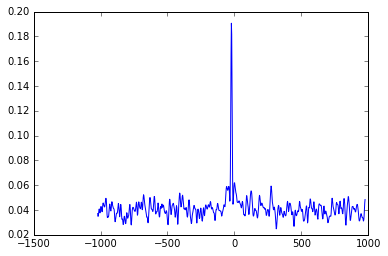

In [121]:


model_orders = GenericSearch.process_model(model.copy(), orders, vsini_primary=vsini_prim, maxvel=1000.0,
                                           debug=False, oversample=1, logspace=False)

corr = Correlate.Correlate(orders, model_orders, addmode='all', outputdir='./',
                           get_weights=False, prim_teff=prim_teff,
                           orderweights=None, debug=False)
corr.x += vbary
ccf = corr['ml']
plt.plot(ccf.x, ccf.y)
print(ccf.x[np.argmax(ccf.y)])

# Just remake all of the detection CCFs

In [7]:
detections.Instrument.unique()

array(['HET', 'IGRINS', 'TS23', 'CHIRON'], dtype=object)

In [9]:
PhoenixLibrary = dict(HET='/media/ExtraSpace/PhoenixGrid/HRS_Grid.hdf5',
                      TS23='/media/ExtraSpace/PhoenixGrid/TS23_Grid.hdf5',
                      CHIRON='/media/ExtraSpace/PhoenixGrid/CHIRON_Grid.hdf5',
                      IGRINS='/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5')
def remeasure_rv(row):
    # 1. Read in the HDF5 dataset
    row_dict = row.to_dict()
    path = '{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.0f}'.format(**row_dict)
    print(path)
    if path not in hdf_int._interfaces[row['Instrument']].hdf5:
        path = '{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.1f}'.format(**row_dict)
    try:
        ds = hdf_int._interfaces[row['Instrument']].hdf5[path]
    except KeyError:
        #ds = hdf_int._interfaces[row['Instrument']].hdf5['{identifier}/{UT_date}/T{Temperature:.0f}_logg4.5_metal{feh:.1f}_addmode-{best_addmode}_vsini{vsini_sec:.1f}'.format(**row_dict)]
        print('Dataset not found for the following row:')
        print(row)
        df = pd.DataFrame(data=dict(addmode=None, RV=np.nan, RV_err=np.nan, CCF=np.nan, vbary=np.nan), index=(0,))
        for key in row.keys():
            df[key] = row[key]
        return df
    
    # 2. Get the appropriate model
    Tvalues = np.atleast_1d(row['Temperature'])
    metal_values = np.atleast_1d(row['feh'])
    logg_values = np.atleast_1d(4.5)
    vsini_values = np.atleast_1d(row['vsini_sec'])
    instrument = row['Instrument']
    hdf5_file = PhoenixLibrary[instrument]
    print(hdf5_file)

    model_list = StellarModel.GetModelList(type='hdf5',
                                           hdf5_file=hdf5_file,
                                           temperature=Tvalues,
                                           metal=metal_values,
                                           logg=logg_values)
    modeldict, processed = StellarModel.MakeModelDicts(model_list, type='hdf5', hdf5_file=hdf5_file,
                                                       vsini_values=vsini_values, vac2air=True, logspace=True)
    model = modeldict[Tvalues[0]][logg_values[0]][metal_values[0]][0.0][vsini_values[0]]
    l_idx = 0
    r_idx = model.size()
    model = Broaden.RotBroad(model[l_idx:r_idx], vsini_values[0] * u.km.to(u.cm), linear=True)
    
    # 3: Read in and process the original datafile
    fname = os.path.join(instrument_dirs[instrument], ds.attrs['fname'])
    header = fits.getheader(fname)
    vbary = GenericSearch.HelCorr_IRAF(header, observatory='mcdonald')
    vsini_prim = StarData.get_vsini([fname])[0]
    spt = StarData.GetData(header['OBJECT']).spectype
    prim_teff = MS.Interpolate('Temperature', spt)
    orders = GenericSearch.Process_Data(fname, vsini=vsini_prim, reject_outliers=True, 
                                        logspacing=True, extensions=True, **settings[instrument])
    Npix = sum([o.size() for o in orders])
    
    # 4. Make the ccf
    model_orders = GenericSearch.process_model(model.copy(), orders, vsini_primary=vsini_prim, maxvel=1000.0,
                                           debug=False, oversample=1, logspace=False)
    corr = Correlate.Correlate(orders, model_orders, addmode='all', outputdir='./',
                               get_weights=False, prim_teff=prim_teff,
                               orderweights=None, debug=False)
    corr.x += vbary

    # 5. Find the maximum velocity for each ccf
    rv_dict = defaultdict(list)
    for addmode in ['ml', 'dc', 'simple']:
        ccf = corr[addmode]
        good = np.abs(ccf.x - ds.attrs['vel_max']) < 25
        #plt.plot(ccf.x[good], ccf.y[good], label=addmode)
        #plt.plot(ccf.x, ccf.y, label=addmode)
        rv, rv_err, ccf = get_rv(ccf.x[good], ccf.y[good], Npix)
        rv_dict['addmode'].append(addmode)
        rv_dict['RV'].append(rv)
        rv_dict['RV_err'].append(rv_err)
        rv_dict['CCF'].append(ccf)
        rv_dict['vbary'].append(vbary)
    #plt.legend(loc='best', fancybox=True)
    
    df = pd.DataFrame(data=rv_dict)
    for key in row.keys():
        df[key] = row[key]
    return df

#out = []
#for _, row in detections.iterrows():
#    out.append(remeasure_rv(row))
#rv_data = pd.concat(out, ignore_index=True)
#rv_data.head()

In [13]:
MS = SpectralTypeRelations.MainSequence()
from Correlate import get_rv
out = []
for _, row in detections.loc[detections.identifier == 'HIP 22958'].iterrows():
    out.append(remeasure_rv(row))
tmp = pd.concat(out, ignore_index=True)
tmp

HIP 22958/2013-09-16/T5900_logg4.5_metal-0.5_addmode-simple_vsini30
/media/ExtraSpace/PhoenixGrid/CHIRON_Grid.hdf5
/home/kgullikson/School/Research/CHIRON_data/20130915/HIP_22958.fits

INFO:root:Getting stellar data for HIP 22958


 83.2
SELECT * FROM star WHERE name IN ('HIP 22958')
Removing order 57
Removing order 56
Removing order 55
Removing order 54
Removing order 53
Removing order 52
Removing order 51
Removing order 50
Removing order 49
Removing order 45
Removing order 44
Removing order 42
Removing order 41
Removing order 36
Warning! Bad region covers the middle of order 24
Removing full order!
Removing order 33
Removing order 28
Removing order 27
Removing order 24


HIP 22958/2014-10-13/T6600_logg4.5_metal-0.5_addmode-simple_vsini30
/media/ExtraSpace/PhoenixGrid/CHIRON_Grid.hdf5
/home/kgullikson/School/Research/CHIRON_data/20141012/HIP_22958.fits

INFO:root:Getting stellar data for HIP 22958


 83.2
Removing order 57
Removing order 56
Removing order 55
Removing order 54
Removing order 53
Removing order 52
Removing order 51
Removing order 50
Removing order 49
Removing order 45
Removing order 44
Removing order 42
Removing order 41
Removing order 36
Warning! Bad region covers the middle of order 24
Removing full order!
Removing order 33
Removing order 28
Removing order 27
Removing order 24




,CCF,RV,RV_err,addmode,vbary,identifier,SpT,configuration,Instrument,Date,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
0,0.0845808860943,68.233309,1.304574,ml,26.02,HIP 22958,B6V,"(5.49B6V + 9.64; .650"")",CHIRON,20130915,...,1,n,n,n,NaN,simple,2013-09-15,5899.991984,216.006675,2013-09-16
1,0.0832353960993,69.083076,1.271617,dc,26.02,HIP 22958,B6V,"(5.49B6V + 9.64; .650"")",CHIRON,20130915,...,1,n,n,n,NaN,simple,2013-09-15,5899.991984,216.006675,2013-09-16
2,0.0688146040978,42.772792,0.618962,simple,26.02,HIP 22958,B6V,"(5.49B6V + 9.64; .650"")",CHIRON,20130915,...,1,n,n,n,NaN,simple,2013-09-15,5899.991984,216.006675,2013-09-16
3,0.0608563428792,21.691466,0.991514,ml,20.98,HIP 22958,B6V,"(5.49B6V + 9.64; .650"")",CHIRON,20141012,...,1,n,n,n,NaN,simple,2014-10-12,6599.994565,216.011699,2014-10-13
4,0.0607652903852,21.764852,0.991377,dc,20.98,HIP 22958,B6V,"(5.49B6V + 9.64; .650"")",CHIRON,20141012,...,1,n,n,n,NaN,simple,2014-10-12,6599.994565,216.011699,2014-10-13
5,0.0388418006644,26.768892,0.920429,simple,20.98,HIP 22958,B6V,"(5.49B6V + 9.64; .650"")",CHIRON,20141012,...,1,n,n,n,NaN,simple,2014-10-12,6599.994565,216.011699,2014-10-13


In [15]:
MS = SpectralTypeRelations.MainSequence()
from Correlate import get_rv
out = []
for _, row in detections.loc[detections.Instrument == 'IGRINS'].iterrows():
    out.append(remeasure_rv(row))
tmp = pd.concat(out, ignore_index=True)
rv_data.loc[rv_data.Instrument == 'IGRINS'] = tmp

HIP 2548/2015-08-06/T6000_logg4.5_metal0.0_addmode-simple_vsini30
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150805/HIP_2548_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 2548


 144.0
Warning, 82 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 17 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 54 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 18 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 14 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 149 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Warning, 169 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 36 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 22
Warning, 10 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Wa

INFO:root:Getting stellar data for HIP 5310


 119.2
Warning, 89 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 68 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 14 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HR 545/2014-10-15/T4500_logg4.5_metal-0.5_addmode-simple_vsini5
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141014/HR_545_telluric_corrected.fits

INFO:root:Getting stellar data for HR 545


 112.0
Warning, 53 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 94 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 6 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 10732/2014-10-15/T5500_logg4.5_metal0.0_addmode-simple_vsini5
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141014/HIP_10732_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 10732


 148.8
Warning, 61 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 58 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 16 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 10732/2015-03-02/T5700_logg4.5_metal0.0_addmode-simple_vsini10
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150301/HIP_10732_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 10732


 148.8
Removing order 43
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 46 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 57 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Removing order 1
Removing order 0


HIP 12332/2014-10-17/T5600_logg4.5_metal0.0_addmode-simple_vsini10
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141016/HIP_12332_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 12332


 106.4
Removing order 43
Warning, 10 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 139 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 18 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Removing order 29
Removing order 28
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Removing order 25
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 137 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 178 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Warning, 1 of 1777 bins contained negative fluxes; they ha

INFO:root:Getting stellar data for HIP 12706


 148.8
Warning, 16 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 8 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 106 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 329 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 15 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 14764/2014-10-16/T5600_logg4.5_metal0.5_addmode-simple_vsini30
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141015/HIP_14764_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 14764


 225.6
Warning, 23 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 10 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Removing order 25
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 146 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 5 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 21 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 16244/2014-10-15/T6200_logg4.5_metal-0.5_addmode-simple_vsini5
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson

INFO:root:Getting stellar data for HIP 16244


 100.0
Removing order 43
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 50 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 6 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 16611/2014-10-16/T5500_logg4.5_metal0.5_addmode-simple_vsini1
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141015/HIP_16611_telluric_corrected.fits

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:42: UserWarning: vsini too small (100000.0). Not broadening!
INFO:root:Getting stellar data for HIP 16611


 108.0
Warning, 118 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 11 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Removing order 26
Removing order 25
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 127 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 288 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 17 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 19949/2014-10-15/T6500_logg4.5_metal-0.5_add

INFO:root:Getting stellar data for HIP 19949


 199.2
Removing order 43
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 42 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 20380/2014-10-15/T6300_logg4.5_metal-0.5_addmode-simple_vsini20
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141014/HIP_20380_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 20380


 115.2
Removing order 43
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 89 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 15 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 20380/2015-03-03/T6700_logg4.5_metal0.0_addmode-simple_vsini20
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150302/HIP_20380_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 20380


 115.2
Warning, 195 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 61 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 61 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 9 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 7 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 28
Warning, 52 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Warning, 27 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Warning, 67 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Warning, 94 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 790 of 1777 bins contain

INFO:root:Getting stellar data for HIP 21589


 71.2
Warning, 124 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 18 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 365 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 630 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 20
Removing order 19
Removing order 2
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 31 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 22833/2014-10-16/T5100_logg4.5_metal0.0_addmo

INFO:root:Getting stellar data for HIP 22833


 140.0
Warning, 97 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 14 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 19 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 24902/2014-10-16/T5700_logg4.5_metal0.0_addmode-simple_vsini30
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141015/HIP_24902_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 24902


 173.6
Warning, 83 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 15 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 25143/2014-10-16/T5800_logg4.5_metal0.0_addmode-simple_vsini30
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141015/HIP_25143_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 25143


 144.0
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 22 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 16 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 25143/2015-03-03/T6000_logg4.5_metal0.5_addmode-simple_vsini30
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150302/HIP_25143_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 25143


 144.0
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 37 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Warning, 7 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 21
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 20
Removing order 19
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 2
Warning, 11 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 38 of 1777 bins contained negative fluxes; they have been set to

INFO:root:Getting stellar data for HIP 26126


 140.0
Removing order 43
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 147 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 138 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Removing order 1
Removing order 0


HIP 39847/2015-03-03/T5800_logg4.5_metal-0.5_addmode-simple_vsini10
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150302/HIP_39847_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 39847


 152.8
Removing order 43
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 7 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 5 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 380 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 708 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Removing order 1
Warning, 12 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 40881/2014-10-17/T4600_logg4.5_metal-0.5_addmode-simple_vsini10
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20141016/HIP_40881_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 40881


 146.4
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 21 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 6 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Removing order 28
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Warning, 6 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Warning, 7 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 173 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 13 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
W

INFO:root:Getting stellar data for HIP 77336


 106.4
Warning, 85 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 37 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 14 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Removing order 29
Removing order 28
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Warning, 8 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Removing order 25
Warning, 26 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 150 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Warning, 19 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 21
Removing order 20
Removing order 19
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 2
Warnin

INFO:root:Getting stellar data for HIP 78821


 52.0
Warning, 158 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 63 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 26 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 6 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Removing order 28
Warning, 9 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Warning, 64 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Warning, 71 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 215 of 1777 bins contained 

INFO:root:Getting stellar data for HIP 80460


 224.0
Warning, 69 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 54 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 21 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Removing order 28
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Warning, 10 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Warning, 37 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 191 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Warning, 12 of 1777 bins contained negative fluxes; they have been set to zer

INFO:root:Getting stellar data for HIP 84606


 127.2
Removing order 43
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 16 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 16 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 85998/2015-07-27/T5500_logg4.5_metal-0.5_addmode-simple_vsini5
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150726/HIP_85998_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 85998


 23.2
Warning, 118 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 72 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 59 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 15 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 29 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 52 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 281 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 85 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Warning, 186 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 22
Warning, 1 of 1777 bins contained negative fluxes; they have been set to 

INFO:root:Getting stellar data for HIP 88818


 144.0
Warning, 88 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 44 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 14 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Removing order 28
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Warning, 29 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 101 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Warning, 6 of 1777 bins contained negative fluxes; they have been set to zero.

INFO:root:Getting stellar data for HIP 88818


 144.0
Warning, 98 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 46 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 50 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 17 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 7 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 211 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 223 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 171 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Warning, 167 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 37 of 1777 bins contained negative fluxes; they have been set to zero.
Removing o

INFO:root:Getting stellar data for HIP 88817


 144.0
Warning, 74 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 51 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 16 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Removing order 28
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Warning, 5 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Removing order 25
Warning, 22 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 210 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 42 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Warning, 8 of 1777 bins contained negative fluxes; they have been set to zero

INFO:root:Getting stellar data for HIP 91118


 104.0
Warning, 18 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 9 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 147 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 327 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 13 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 93805/2014-07-14/T4000_logg4.5_metal-0.5_addmode-simple_vsini5
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikso

INFO:root:Getting stellar data for HIP 93805


 152.8
SELECT * FROM star WHERE name IN ('HIP 93805')
Warning, 37 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 10 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 197 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 114 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 20 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Removing order 28
Removing order 27
Warning, 393 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 26
Warning, 8 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 14 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Removing order 24
Warning, 761 of 1777 bins contained negative fluxes; they have 


/home/kgullikson/School/Research/IGRINS_data/20150426/HIP93805_telluric_corrected.fits

INFO:root:Getting stellar data for HIP93805
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): simbak.cfa.harvard.edu


 None
SELECT * FROM star WHERE name IN ('HIP93805')
Removing order 43
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Removing order 1
Removing order 0


HIP 100221/2015-07-27/T5300_logg4.5_metal-0.5_addmode-simple_vsini20
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150726/HIP_100221_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 100221


 122.4
SELECT * FROM star WHERE name IN ('HIP 100221')
Warning, 113 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 84 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 28 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Warning, 53 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 142 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 340 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 86 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Warning, 249 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 47 of 1777 bins contained negativ

INFO:root:Getting stellar data for HIP 100907


 106.4
SELECT * FROM star WHERE name IN ('HIP 100907')
Removing order 43
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Warning, 100 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 185 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 4 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 23 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 100907/2015-07-27/T5100_logg4.5_metal-0.5_addmode-simple_vsini10
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150726/HIP_100907_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 100907


 106.4
Warning, 117 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 70 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 66 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 17 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 19 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 132 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 224 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Warning, 213 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 22
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 21
Removing order 20
Removing order 19
Removing order 2
W

INFO:root:Getting stellar data for HIP 103298


 127.2
SELECT * FROM star WHERE name IN ('HIP 103298')
Warning, 68 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 5 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 27
Removing order 26
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Warning, 5 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 186 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 357 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 2 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 24 of 1777 bi

INFO:root:Getting stellar data for HIP 103298


 127.2
Warning, 138 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 78 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 17 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 5 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Warning, 32 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 55 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 414 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 40 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Warning, 291 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 114

INFO:root:Getting stellar data for HIP 109521


 115.2
SELECT * FROM star WHERE name IN ('HIP 109521')
Removing order 43
Removing order 42
Removing order 41
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Removing order 25
Removing order 24
Removing order 23
Removing order 22
Removing order 21
Removing order 20
Removing order 19
Removing order 2
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 1
Warning, 12 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 0


HIP 115115/2015-07-27/T5100_logg4.5_metal0.0_addmode-simple_vsini10
/media/ExtraSpace/PhoenixGrid/IGRINS_Grid.hdf5
/home/kgullikson/School/Research/IGRINS_data/20150726/HIP_115115_telluric_corrected.fits

INFO:root:Getting stellar data for HIP 115115


 115.2
SELECT * FROM star WHERE name IN ('HIP 115115')
Warning, 151 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 43
Warning, 97 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 42
Warning, 15 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 41
Warning, 1 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 29
Removing order 28
Removing order 27
Removing order 26
Warning, 3 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 25
Warning, 107 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 24
Warning, 314 of 1777 bins contained negative fluxes; they have been set to zero.
Removing order 23
Warning, 288 of 1777 bins contained negative fluxes; they have been set to zero.
Warning, 71 of 1777 bins contained negative

In [16]:
rv_data.loc[rv_data.Instrument == 'IGRINS', ['RV', 'RV_err', 'addmode', 'CCF', 'identifier', 'Instrument', 'Date']]

,RV,RV_err,addmode,CCF,identifier,Instrument,Date
3,7.832654,1.178236,ml,0.0953533067486,HIP 5310,IGRINS,20141014
4,7.829693,1.183559,dc,0.095138783279,HIP 5310,IGRINS,20141014
5,8.047723,0.655747,simple,0.0758713033394,HIP 5310,IGRINS,20141014
9,-3.977840,0.294700,ml,0.118854744631,HIP 10732,IGRINS,20141014
10,-3.976440,0.295808,dc,0.118557847384,HIP 10732,IGRINS,20141014
11,-3.686595,0.314489,simple,0.104706065467,HIP 10732,IGRINS,20141014
12,-3.803059,0.490990,ml,0.0976657267971,HIP 10732,IGRINS,20150301
13,-3.765976,0.496110,dc,0.0971187210619,HIP 10732,IGRINS,20150301
14,-3.817681,0.597193,simple,0.0723571417177,HIP 10732,IGRINS,20150301
24,-14.748714,0.332177,ml,0.0895290494725,HIP 16244,IGRINS,20141014


In [17]:
rv_data.to_csv('Companion_RV_data.csv', sep='|', encoding='utf-8')

In [15]:
detections.loc[detections.identifier == 'HIP 46283']

,identifier,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,feh,significance,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
256,HIP 46283,B6V,B6V,CHIRON,20131122,9400,-69.450,10,0.5,NaN,...,1,n,Y,n,NaN,simple,2013-11-22,9400,215,2013-11-23
257,HIP 46283,B6V,B6V,CHIRON,20140223,9200,14.625,10,0.5,NaN,...,1,n,Y,n,NaN,simple,2014-02-23,9200,215,2014-02-24
258,HIP 46283,B6V,B6V,CHIRON,20140315,9200,-75.273,10,0.5,NaN,...,1,n,Y,n,NaN,simple,2014-03-15,9200,215,2014-03-16


/media/ExtraSpace/PhoenixGrid/CHIRON_Grid.hdf5
/home/kgullikson/School/Research/CHIRON_data/20131122/HIP_46283.fits

INFO:root:Getting stellar data for HIP 46283


 162.4
Removing order 57
Removing order 56
Removing order 55
Removing order 54
Removing order 53
Removing order 52
Removing order 51
Removing order 50
Removing order 49
Removing order 45
Removing order 44
Removing order 42
Removing order 41
Removing order 36
Warning! Bad region covers the middle of order 24
Removing full order!
Removing order 33
Removing order 28
Removing order 27
Removing order 24




,CCF,RV,RV_err,addmode,vbary,identifier,SpT,configuration,Instrument,Date,...,Rank,Keck,VLT,Gemini,Imaging_Detecton,best_addmode,parsed_date,Tmeas,Tmeas_err,UT_date
0,0.328374803399,-69.095878,0.060594,ml,12.95,HIP 46283,B6V,B6V,CHIRON,20131122,...,1,n,Y,n,NaN,simple,2013-11-22,9400,215,2013-11-23
1,0.319020697539,-69.087634,0.065074,dc,12.95,HIP 46283,B6V,B6V,CHIRON,20131122,...,1,n,Y,n,NaN,simple,2013-11-22,9400,215,2013-11-23
2,0.272770348313,-69.161713,0.076850,simple,12.95,HIP 46283,B6V,B6V,CHIRON,20131122,...,1,n,Y,n,NaN,simple,2013-11-22,9400,215,2013-11-23


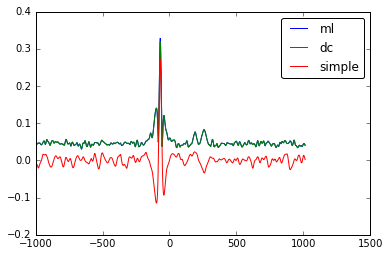

In [24]:
import Correlate
import StellarModel
import Broaden
from astropy import units as u, constants
from astropy.io import fits
import GenericSearch
import StarData
import SpectralTypeRelations
import Mamajek_Table
MS = SpectralTypeRelations.MainSequence()
MT = Mamajek_Table.MamajekTable()
reload(Correlate)
get_rv = Correlate.get_rv
remeasure_rv(detections.loc[256])